# Single-task PushWorld Training (All Environment)

In [1]:
# Install if needed
!pip install "xminigrid[baselines] @ git+https://github.com/jugheadjones10/xland-minigrid.git"

  Cloning https://github.com/jugheadjones10/xland-minigrid.git to /tmp/pip-install-rz4jbvr1/xminigrid_9e494664ba1445d7ad0180f8230938c8
  Running command git clone --filter=blob:none --quiet https://github.com/jugheadjones10/xland-minigrid.git /tmp/pip-install-rz4jbvr1/xminigrid_9e494664ba1445d7ad0180f8230938c8
  Resolved https://github.com/jugheadjones10/xland-minigrid.git to commit d132c0a6310cf25fd14c611dc5612c51087c2be9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 8.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 MB 30.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.5/324.5 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 66.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.5/365.5 k

In [2]:
# !pip install --upgrade jax==0.6.2 jaxlib==0.6.2

In [3]:
# !pip install --upgrade "jax[cuda12]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

In [4]:
# !pip install --upgrade git+https://github.com/deepmind/distrax.git

In [5]:
import os
import shutil
import time #noqa
import os #noqa
import math # noqa
from typing import TypedDict, Optional, Literal #noqa
import numpy as np #noqa
import importlib #noqa
import os #noqa
import imageio #noqa

import jax #noqa
import jax.numpy as jnp #noqa
import jax.tree_util as jtu #noqa
import flax #noqa
import flax.linen as nn #noqa
from flax.training import orbax_utils #noqa

import jax.core
import jax.interpreters.xla as _xla

# restore the name that distrax still expects
# _xla.pytype_aval_mappings = jax.core.pytype_aval_mappings

import distrax #noqa
import orbax #noqa
import optax #noqa
import imageio #noqa
import wandb #noqa
import matplotlib.pyplot as plt #noqa

from flax import struct #noqa
from flax.typing import Dtype #noqa
from flax.linen.dtypes import promote_dtype #noqa
from flax.linen.initializers import glorot_normal, orthogonal, zeros_init #noqa
from flax.training.train_state import TrainState #noqa
from flax.jax_utils import replicate, unreplicate #noqa
from dataclasses import asdict, dataclass #noqa
from functools import partial #noqa

import xminigrid.envs.pushworld as pushworld
from xminigrid.envs.pushworld.benchmarks import Benchmark, BenchmarkAll
from xminigrid.envs.pushworld.constants import Tiles, NUM_TILES, SUCCESS_REWARD, LEVEL0_ALL_SIZE
from xminigrid.envs.pushworld.environment import Environment, EnvParams, EnvParamsT
from xminigrid.envs.pushworld.envs.single_task_pushworld import SingleTaskPushWorldEnvironment, SingleTaskPushWorldEnvParams
from xminigrid.envs.pushworld.envs.meta_task_pushworld import MetaTaskPushWorldEnvironment
# Import level 0 "all" environments
from xminigrid.envs.pushworld.envs.single_task_all_pushworld import SingleTaskPushWorldEnvironmentAll
from xminigrid.envs.pushworld.envs.meta_task_all_pushworld import MetaTaskPushWorldEnvironmentAll
from xminigrid.envs.pushworld.scripts.upload import encode_puzzle
from xminigrid.envs.pushworld.wrappers import GoalObservationWrapper, GymAutoResetWrapper, Wrapper
from xminigrid.envs.pushworld.types import State, TimeStep, StepType, EnvCarry, PushWorldPuzzle, PushWorldPuzzleAll
from xminigrid.envs.pushworld.grid import get_obs_from_puzzle
from IPython.display import Video, HTML, display

2025-08-05 05:11:36.268234: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754370696.449843      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754370696.503145      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO:2025-08-05 05:11:50,844:jax._src.xla_bridge:924: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-08-05 05:11:50,856:jax._src.xla_bridge:924: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


## Networks

In [6]:
# Model adapted from minigrid baselines:
# https://github.com/lcswillems/rl-starter-files/blob/master/model.py


class GRU(nn.Module):
    hidden_dim: int
    dtype: Optional[Dtype] = None
    param_dtype: Dtype = jnp.float32

    @nn.compact
    def __call__(self, xs, init_state):
        seq_len, input_dim = xs.shape
        # this init might not be optimal, for example bias for reset gate should be -1 (for now ok)
        Wi = self.param("Wi", glorot_normal(in_axis=1, out_axis=0), (self.hidden_dim * 3, input_dim), self.param_dtype)
        Wh = self.param("Wh", orthogonal(column_axis=0), (self.hidden_dim * 3, self.hidden_dim), self.param_dtype)
        bi = self.param("bi", zeros_init(), (self.hidden_dim * 3,), self.param_dtype)
        bn = self.param("bn", zeros_init(), (self.hidden_dim,), self.param_dtype)

        def _step_fn(h, x):
            igates = jnp.split(Wi @ x + bi, 3)
            hgates = jnp.split(Wh @ h, 3)

            reset = nn.sigmoid(igates[0] + hgates[0])
            update = nn.sigmoid(igates[1] + hgates[1])
            new = nn.tanh(igates[2] + reset * (hgates[2] + bn))
            next_h = (1 - update) * new + update * h

            return next_h, next_h

        # cast to the computation dtype
        xs, init_state, Wi, Wh, bi, bn = promote_dtype(xs, init_state, Wi, Wh, bi, bn, dtype=self.dtype)

        last_state, all_states = jax.lax.scan(_step_fn, init=init_state, xs=xs)
        return all_states, last_state


class RNNModel(nn.Module):
    hidden_dim: int
    num_layers: int
    dtype: Optional[Dtype] = None
    param_dtype: Dtype = jnp.float32

    @nn.compact
    def __call__(self, xs, init_state):
        # xs: [seq_len, input_dim]
        # init_state: [num_layers, hidden_dim]
        outs, states = [], []
        for layer in range(self.num_layers):
            xs, state = GRU(self.hidden_dim, self.dtype, self.param_dtype)(xs, init_state[layer])
            outs.append(xs)
            states.append(state)

        # sum outputs from all layers, kinda like in ResNet
        return jnp.array(outs).sum(0), jnp.array(states)


BatchedRNNModel = flax.linen.vmap(
    RNNModel, variable_axes={"params": None}, split_rngs={"params": False}, axis_name="batch"
)


class EmbeddingEncoder(nn.Module):
    emb_dim: int = 16
    dtype: Optional[Dtype] = None
    param_dtype: Dtype = jnp.float32

    @nn.compact
    def __call__(self, img):
        entity_emb = nn.Embed(NUM_TILES, self.emb_dim, self.dtype, self.param_dtype)

        # [..., channels]
        img_emb = entity_emb(img[..., 0])
        return img_emb


class ActorCriticInput(TypedDict):
    obs: jax.Array
    prev_action: jax.Array
    prev_reward: jax.Array


class ActorCriticRNN(nn.Module):
    num_actions: int
    obs_emb_dim: int = 16
    action_emb_dim: int = 16
    rnn_hidden_dim: int = 64
    rnn_num_layers: int = 1
    head_hidden_dim: int = 64
    img_obs: bool = False
    dtype: Optional[Dtype] = None
    param_dtype: Dtype = jnp.float32

    @nn.compact
    def __call__(self, inputs: ActorCriticInput, hidden: jax.Array) -> tuple[distrax.Categorical, jax.Array, jax.Array]:
        B, S = inputs["obs"].shape[:2]

        # encoder from https://github.com/lcswillems/rl-starter-files/blob/master/model.py
        if self.img_obs:
            img_encoder = nn.Sequential(
                [
                    nn.Conv(
                        16,
                        (3, 3),
                        strides=2,
                        padding="VALID",
                        kernel_init=orthogonal(math.sqrt(2)),
                        dtype=self.dtype,
                        param_dtype=self.param_dtype,
                    ),
                    nn.relu,
                    nn.Conv(
                        32,
                        (3, 3),
                        strides=2,
                        padding="VALID",
                        kernel_init=orthogonal(math.sqrt(2)),
                        dtype=self.dtype,
                        param_dtype=self.param_dtype,
                    ),
                    nn.relu,
                    nn.Conv(
                        32,
                        (3, 3),
                        strides=2,
                        padding="VALID",
                        kernel_init=orthogonal(math.sqrt(2)),
                        dtype=self.dtype,
                        param_dtype=self.param_dtype,
                    ),
                    nn.relu,
                    nn.Conv(
                        32,
                        (3, 3),
                        strides=2,
                        padding="VALID",
                        kernel_init=orthogonal(math.sqrt(2)),
                        dtype=self.dtype,
                        param_dtype=self.param_dtype,
                    ),
                ]
            )
        else:
            img_encoder = nn.Sequential(
                [
                    # For small dims nn.Embed is extremely slow in bf16, so we leave everything in default dtypes
                    EmbeddingEncoder(emb_dim=self.obs_emb_dim),
                    nn.Conv(
                        16,
                        (2, 2),
                        padding="VALID",
                        kernel_init=orthogonal(math.sqrt(2)),
                        dtype=self.dtype,
                        param_dtype=self.param_dtype,
                    ),
                    nn.relu,
                    nn.Conv(
                        32,
                        (2, 2),
                        padding="VALID",
                        kernel_init=orthogonal(math.sqrt(2)),
                        dtype=self.dtype,
                        param_dtype=self.param_dtype,
                    ),
                    nn.relu,
                    nn.Conv(
                        64,
                        (2, 2),
                        padding="VALID",
                        kernel_init=orthogonal(math.sqrt(2)),
                        dtype=self.dtype,
                        param_dtype=self.param_dtype,
                    ),
                    nn.relu,
                ]
            )
        action_encoder = nn.Embed(self.num_actions, self.action_emb_dim)

        rnn_core = BatchedRNNModel(
            self.rnn_hidden_dim, self.rnn_num_layers, dtype=self.dtype, param_dtype=self.param_dtype
        )
        actor = nn.Sequential(
            [
                nn.Dense(
                    self.head_hidden_dim, kernel_init=orthogonal(2), dtype=self.dtype, param_dtype=self.param_dtype
                ),
                nn.tanh,
                nn.Dense(
                    self.num_actions, kernel_init=orthogonal(0.01), dtype=self.dtype, param_dtype=self.param_dtype
                ),
            ]
        )
        critic = nn.Sequential(
            [
                nn.Dense(
                    self.head_hidden_dim, kernel_init=orthogonal(2), dtype=self.dtype, param_dtype=self.param_dtype
                ),
                nn.tanh,
                nn.Dense(1, kernel_init=orthogonal(1.0), dtype=self.dtype, param_dtype=self.param_dtype),
            ]
        )

        # [batch_size, seq_len, ...]
        obs_emb = img_encoder(inputs["obs"].astype(jnp.int32)).reshape(B, S, -1)
        act_emb = action_encoder(inputs["prev_action"])

        # [batch_size, seq_len, hidden_dim + act_emb_dim + 1]
        out = jnp.concatenate([obs_emb, act_emb, inputs["prev_reward"][..., None]], axis=-1)

        # core networks
        out, new_hidden = rnn_core(out, hidden)

        # casting to full precision for the loss, as softmax/log_softmax
        # (inside Categorical) is not stable in bf16
        logits = actor(out).astype(jnp.float32)

        dist = distrax.Categorical(logits=logits)
        values = critic(out)

        return dist, jnp.squeeze(values, axis=-1), new_hidden

    def initialize_carry(self, batch_size):
        return jnp.zeros((batch_size, self.rnn_num_layers, self.rnn_hidden_dim), dtype=self.dtype)

## Utils

In [7]:
# utilities for PPO training and evaluation


# Training stuff
class Transition(struct.PyTreeNode):
    done: jax.Array
    action: jax.Array
    value: jax.Array
    reward: jax.Array
    log_prob: jax.Array
    # for obs
    obs: jax.Array
    # for rnn policy
    prev_action: jax.Array
    prev_reward: jax.Array


def calculate_gae(
    transitions: Transition,
    last_val: jax.Array,
    gamma: float,
    gae_lambda: float,
) -> tuple[jax.Array, jax.Array]:
    # single iteration for the loop
    def _get_advantages(gae_and_next_value, transition):
        gae, next_value = gae_and_next_value
        delta = transition.reward + gamma * next_value * (1 - transition.done) - transition.value
        gae = delta + gamma * gae_lambda * (1 - transition.done) * gae
        return (gae, transition.value), gae

    _, advantages = jax.lax.scan(
        _get_advantages,
        (jnp.zeros_like(last_val), last_val),
        transitions,
        reverse=True,
    )
    # advantages and values (Q)
    return advantages, advantages + transitions.value


def ppo_update_networks(
    train_state: TrainState,
    transitions: Transition,
    init_hstate: jax.Array,
    advantages: jax.Array,
    targets: jax.Array,
    clip_eps: float,
    vf_coef: float,
    ent_coef: float,
):
    # NORMALIZE ADVANTAGES
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    def _loss_fn(params):
        # RERUN NETWORK
        dist, value, _ = train_state.apply_fn(
            params,
            {
                # [batch_size, seq_len, ...]
                "obs": transitions.obs,
                "prev_action": transitions.prev_action,
                "prev_reward": transitions.prev_reward,
            },
            init_hstate,
        )
        log_prob = dist.log_prob(transitions.action)

        # CALCULATE VALUE LOSS
        value_pred_clipped = transitions.value + (value - transitions.value).clip(-clip_eps, clip_eps)
        value_loss = jnp.square(value - targets)
        value_loss_clipped = jnp.square(value_pred_clipped - targets)
        value_loss = 0.5 * jnp.maximum(value_loss, value_loss_clipped).mean()

        # TODO: ablate this!
        # value_loss = jnp.square(value - targets).mean()

        # CALCULATE ACTOR LOSS
        ratio = jnp.exp(log_prob - transitions.log_prob)
        actor_loss1 = advantages * ratio
        actor_loss2 = advantages * jnp.clip(ratio, 1.0 - clip_eps, 1.0 + clip_eps)
        actor_loss = -jnp.minimum(actor_loss1, actor_loss2).mean()
        entropy = dist.entropy().mean()

        total_loss = actor_loss + vf_coef * value_loss - ent_coef * entropy
        return total_loss, (value_loss, actor_loss, entropy)

    (loss, (vloss, aloss, entropy)), grads = jax.value_and_grad(_loss_fn, has_aux=True)(train_state.params)
    (loss, vloss, aloss, entropy, grads) = jax.lax.pmean((loss, vloss, aloss, entropy, grads), axis_name="devices")
    train_state = train_state.apply_gradients(grads=grads)
    update_info = {
        "total_loss": loss,
        "value_loss": vloss,
        "actor_loss": aloss,
        "entropy": entropy,
    }
    return train_state, update_info


# for evaluation (evaluate for N consecutive episodes, sum rewards)
# N=1 single task, N>1 for meta-RL
class RolloutStats(struct.PyTreeNode):
    reward: jax.Array = struct.field(default_factory=lambda: jnp.asarray(0.0))
    length: jax.Array = struct.field(default_factory=lambda: jnp.asarray(0))
    episodes: jax.Array = struct.field(default_factory=lambda: jnp.asarray(0))
    solved: jax.Array = struct.field(default_factory=lambda: jnp.asarray(0))


# for tracking per-episode statistics during meta-RL evaluation
class MetaRolloutStats(struct.PyTreeNode):
    episode_rewards: jax.Array  # Shape: [max_episodes] - reward for each episode
    episode_lengths: jax.Array  # Shape: [max_episodes] - length of each episode
    episode_solved: jax.Array  # Shape: [max_episodes] - whether each episode was solved
    total_reward: jax.Array  # Scalar - total reward across all episodes
    num_episodes_completed: jax.Array  # Scalar - number of episodes actually completed


def rollout(
    rng: jax.Array,
    env: Environment,
    env_params: EnvParams,
    eval_puzzle: PushWorldPuzzleAll,
    train_state: TrainState,
    init_hstate: jax.Array,
    num_consecutive_episodes: int = 1,
) -> RolloutStats:
    def _cond_fn(carry):
        rng, stats, timestep, prev_action, prev_reward, hstate = carry
        return jnp.less(stats.episodes, num_consecutive_episodes)

    def _body_fn(carry):
        rng, stats, timestep, prev_action, prev_reward, hstate = carry

        rng, _rng = jax.random.split(rng)
        dist, _, hstate = train_state.apply_fn(
            train_state.params,
            {
                # We add single channel dimension to end of obs
                "obs": timestep.observation[None, None, ...],
                "prev_action": prev_action[None, None, ...],
                "prev_reward": prev_reward[None, None, ...],
            },
            hstate,
        )
        action = dist.sample(seed=_rng).squeeze()
        timestep = env.step(env_params, timestep, action)

        solved_flag = ((timestep.reward == SUCCESS_REWARD) & (timestep.last() == 1)).astype(jnp.int32)
        stats = stats.replace(
            reward=stats.reward + timestep.reward,
            length=stats.length + 1,
            episodes=stats.episodes + timestep.last(),
            solved=solved_flag,
        )
        carry = (rng, stats, timestep, action, timestep.reward, hstate)
        return carry

    env_params = env_params.replace(puzzle=eval_puzzle)
    timestep = env.eval_reset(env_params, rng)
    prev_action = jnp.asarray(0)
    prev_reward = jnp.asarray(0)
    init_carry = (rng, RolloutStats(), timestep, prev_action, prev_reward, init_hstate)

    final_carry = jax.lax.while_loop(_cond_fn, _body_fn, init_val=init_carry)
    return final_carry[1]


def meta_rollout(
    rng: jax.Array,
    env: Environment,
    env_params: EnvParams,
    eval_puzzle: PushWorldPuzzleAll,
    train_state: TrainState,
    init_hstate: jax.Array,
    num_consecutive_episodes: int = 1,
) -> MetaRolloutStats:
    """Rollout that tracks statistics for each individual episode."""

    def _cond_fn(carry):
        rng, stats, timestep, prev_action, prev_reward, hstate, current_episode_reward, current_episode_length = carry
        return jnp.less(stats.num_episodes_completed, num_consecutive_episodes)

    def _body_fn(carry):
        rng, stats, timestep, prev_action, prev_reward, hstate, current_episode_reward, current_episode_length = carry

        rng, _rng = jax.random.split(rng)
        dist, _, hstate = train_state.apply_fn(
            train_state.params,
            {
                # We add single channel dimension to end of obs_img
                "obs": timestep.observation[None, None, ...],
                "prev_action": prev_action[None, None, ...],
                "prev_reward": prev_reward[None, None, ...],
            },
            hstate,
        )
        action = dist.sample(seed=_rng).squeeze()
        timestep = env.step(env_params, timestep, action)

        # Update current episode accumulators
        current_episode_reward = current_episode_reward + timestep.reward
        current_episode_length = current_episode_length + 1

        # Check if episode ended
        episode_ended = timestep.last()
        solved_flag = ((timestep.reward == SUCCESS_REWARD) & (episode_ended == 1)).astype(jnp.int32)

        # When episode ends, store the episode stats
        episode_idx = stats.num_episodes_completed
        new_episode_rewards = stats.episode_rewards.at[episode_idx].set(
            jnp.where(episode_ended, current_episode_reward, stats.episode_rewards[episode_idx])
        )
        new_episode_lengths = stats.episode_lengths.at[episode_idx].set(
            jnp.where(episode_ended, current_episode_length, stats.episode_lengths[episode_idx])
        )
        new_episode_solved = stats.episode_solved.at[episode_idx].set(
            jnp.where(episode_ended, solved_flag, stats.episode_solved[episode_idx])
        )

        # Update stats
        stats = stats.replace(
            episode_rewards=new_episode_rewards,
            episode_lengths=new_episode_lengths,
            episode_solved=new_episode_solved,
            total_reward=stats.total_reward + timestep.reward,
            num_episodes_completed=stats.num_episodes_completed + episode_ended,
        )

        # Reset episode accumulators when episode ends
        current_episode_reward = jnp.where(episode_ended, 0.0, current_episode_reward)
        current_episode_length = jnp.where(episode_ended, 0, current_episode_length)

        carry = (rng, stats, timestep, action, timestep.reward, hstate, current_episode_reward, current_episode_length)
        return carry

    # Initialize episode tracking arrays
    episode_rewards = jnp.zeros(num_consecutive_episodes)
    episode_lengths = jnp.zeros(num_consecutive_episodes, dtype=jnp.int32)
    episode_solved = jnp.zeros(num_consecutive_episodes, dtype=jnp.int32)

    initial_stats = MetaRolloutStats(
        episode_rewards=episode_rewards,
        episode_lengths=episode_lengths,
        episode_solved=episode_solved,
        total_reward=jnp.asarray(0.0),
        num_episodes_completed=jnp.asarray(0),
    )

    env_params = env_params.replace(puzzle=eval_puzzle)
    timestep = env.eval_reset(env_params, rng)
    prev_action = jnp.asarray(0)
    prev_reward = jnp.asarray(0)
    current_episode_reward = jnp.asarray(0.0)
    current_episode_length = jnp.asarray(0)

    init_carry = (
        rng,
        initial_stats,
        timestep,
        prev_action,
        prev_reward,
        init_hstate,
        current_episode_reward,
        current_episode_length,
    )

    final_carry = jax.lax.while_loop(_cond_fn, _body_fn, init_val=init_carry)
    return final_carry[1]

## Training

In [10]:
# this will be default in new jax versions anyway
# jax.config.update("jax_threefry_partitionable", True)


def ppo_update_networks(
    train_state: TrainState,
    transitions: Transition,
    init_hstate: jax.Array,
    advantages: jax.Array,
    targets: jax.Array,
    clip_eps: float,
    vf_coef: float,
    ent_coef: float
  ):
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    def _loss_fn(params):
        dist, value, _ = train_state.apply_fn(
            params,
            {
                # [batch_size, seq_len, ...]
                "obs": transitions.obs,
                "prev_action": transitions.prev_action,
                "prev_reward": transitions.prev_reward,
            },
            init_hstate,
        )
        log_prob = dist.log_prob(transitions.action)

        value_pred_clipped = transitions.value + (value - transitions.value).clip(-clip_eps, clip_eps)
        value_loss = jnp.square(value - targets)
        value_loss_clipped = jnp.square(value_pred_clipped - targets)
        value_loss = 0.5 * jnp.maximum(value_loss, value_loss_clipped).mean()


        ratio = jnp.exp(log_prob - transitions.log_prob)
        actor_loss1 = advantages * ratio
        actor_loss2 = advantages * jnp.clip(ratio, 1.0 - clip_eps, 1.0 + clip_eps)
        actor_loss = -jnp.minimum(actor_loss1, actor_loss2).mean()
        entropy = dist.entropy().mean()

        total_loss = actor_loss + vf_coef * value_loss - ent_coef * entropy
        return total_loss, (value_loss, actor_loss, entropy)

    (loss, (vloss, aloss, entropy)), grads = jax.value_and_grad(_loss_fn, has_aux=True)(train_state.params)
    train_state = train_state.apply_gradients(grads=grads)

    update_info = {
        "total_loss": loss,
        "value_loss": vloss,
        "actor_loss": aloss,
        "entropy": entropy,
    }
    return train_state, update_info

@dataclass
class TrainConfig:
    project: str = "PushWorld"
    group: str = "default"
    name: str = "single-task-ppo-pushworld"
    benchmark_id: str = "level0_mini"
    track: bool = False
    checkpoint_path: Optional[str] = None
    upload_model: bool = False

    train_test_same: bool = False
    num_train: Optional[int] = None
    num_test: Optional[int] = None

    img_obs: bool = False
    obs_emb_dim: int = 16
    action_emb_dim: int = 16
    rnn_hidden_dim: int = 1024
    rnn_num_layers: int = 1
    head_hidden_dim: int = 256
    enable_bf16: bool = False
    num_envs: int = 8192
    num_steps: int = 16
    update_epochs: int = 1
    num_minibatches: int = 16
    total_timesteps: int = 1_000_000
    lr: float = 0.001
    clip_eps: float = 0.2
    gamma: float = 0.99
    gae_lambda: float = 0.95
    ent_coef: float = 0.01
    vf_coef: float = 0.5
    max_grad_norm: float = 0.5
    eval_episodes: int = 80
    seed: int = 42
    puzzle_seed: int = 42
    eval_seed: int = 42

    def __post_init__(self):
        num_devices = jax.local_device_count()
        self.num_envs_per_device = self.num_envs // num_devices
        self.total_timesteps_per_device = self.total_timesteps // num_devices
        self.eval_episodes_per_device = self.eval_episodes // num_devices
        assert self.num_envs % num_devices == 0
        self.num_updates = self.total_timesteps_per_device // self.num_steps // self.num_envs_per_device
        print(f"Num devices: {num_devices}, Num updates: {self.num_updates}")


def make_states(config: TrainConfig):
    # for learning rate scheduling
    env = SingleTaskPushWorldEnvironmentAll()
    env_params = env.default_params()
    env = GymAutoResetWrapper(env)

    benchmark = pushworld.load_all_benchmark(config.benchmark_id)

    puzzle_rng = jax.random.key(config.puzzle_seed)
    train_rng, test_rng = jax.random.split(puzzle_rng)

    if config.num_train is not None:
        assert config.num_train <= benchmark.num_train_puzzles(), (
            "num_train is larger than num train available in benchmark"
        )
        perm = jax.random.permutation(train_rng, benchmark.num_train_puzzles())
        idxs = perm[: config.num_train]
        benchmark = benchmark.replace(train_puzzles=benchmark.train_puzzles[idxs])
    else:
        config.num_train = benchmark.num_train_puzzles()

    if config.num_test is not None:
        assert config.num_test <= benchmark.num_test_puzzles(), (
            "num_test is larger than num test available in benchmark"
        )
        perm = jax.random.permutation(test_rng, benchmark.num_test_puzzles())
        idxs = perm[: config.num_test]
        benchmark = benchmark.replace(test_puzzles=benchmark.test_puzzles[idxs])
    else:
        config.num_test = benchmark.num_test_puzzles()

    if config.train_test_same:
        benchmark = benchmark.replace(test_puzzles=benchmark.train_puzzles)
        config.num_test = config.num_train


    rng = jax.random.key(config.seed)
    rng, _rng = jax.random.split(rng)

    network = ActorCriticRNN(
        num_actions=env.num_actions(env_params),
        obs_emb_dim=config.obs_emb_dim,
        action_emb_dim=config.action_emb_dim,
        rnn_hidden_dim=config.rnn_hidden_dim,
        rnn_num_layers=config.rnn_num_layers,
        head_hidden_dim=config.head_hidden_dim,
        img_obs=config.img_obs,
        dtype=jnp.bfloat16 if config.enable_bf16 else None,
    )

    shapes = env.observation_shape(env_params)

    init_obs = {
        "obs": jnp.zeros((config.num_envs_per_device, 1, *shapes)),
        "prev_action": jnp.zeros((config.num_envs_per_device, 1), dtype=jnp.int32),
        "prev_reward": jnp.zeros((config.num_envs_per_device, 1)),
    }
    init_hstate = network.initialize_carry(batch_size=config.num_envs_per_device)

    network_params = network.init(_rng, init_obs, init_hstate)

    return rng, env, env_params, benchmark, init_hstate, network, network_params


def make_train(
    env: Environment,
    env_params: EnvParams,
    benchmark: BenchmarkAll,
    config: TrainConfig,
):
    def train(
        rng: jax.Array,
        lr: jax.Array,
        network: jax.Array,
        network_params: jax.Array,
        init_hstate: jax.Array,
    ):

        def linear_schedule(count):
          frac = 1.0 - (count // (config.num_minibatches * config.update_epochs)) / config.num_updates
          return lr * frac

        tx = optax.chain(
            optax.clip_by_global_norm(config.max_grad_norm),
            optax.inject_hyperparams(optax.adam)(learning_rate=linear_schedule, eps=1e-8),  # eps=1e-5
        )
        train_state = TrainState.create(apply_fn=network.apply, params=network_params, tx=tx)

        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config.num_envs_per_device)

        puzzle_env_params = env_params.replace(benchmark=benchmark)

        timestep = jax.vmap(env.reset, in_axes=(None, 0))(puzzle_env_params, reset_rng)
        prev_action = jnp.zeros(config.num_envs_per_device, dtype=jnp.int32)
        prev_reward = jnp.zeros(config.num_envs_per_device)

        # TRAIN LOOP
        def _update_step(runner_state, update_idx):
            # jax.debug.print("Update step: {}", update_idx)

            # COLLECT TRAJECTORIES
            def _env_step(runner_state, _):
                rng, train_state, prev_timestep, prev_action, prev_reward, prev_hstate = runner_state

                rng, _rng = jax.random.split(rng)
                dist, value, hstate = train_state.apply_fn(
                    train_state.params,
                    {
                        # [batch_size, seq_len=1, ...]
                        "obs": prev_timestep.observation[:, None],
                        "prev_action": prev_action[:, None],
                        "prev_reward": prev_reward[:, None],
                    },
                    prev_hstate,
                )
                action, log_prob = dist.sample_and_log_prob(seed=_rng)
                action, value, log_prob = action.squeeze(1), value.squeeze(1), log_prob.squeeze(1)

                timestep = jax.vmap(env.step, in_axes=(None, 0, 0))(puzzle_env_params, prev_timestep, action)
                transition = Transition(
                    done=timestep.last(),
                    action=action,
                    value=value,
                    reward=timestep.reward,
                    log_prob=log_prob,
                    obs=prev_timestep.observation,
                    prev_action=prev_action,
                    prev_reward=prev_reward,
                )
                runner_state = (rng, train_state, timestep, action, timestep.reward, hstate)
                return runner_state, transition

            initial_hstate = runner_state[-1]
            runner_state, transitions = jax.lax.scan(_env_step, runner_state, None, config.num_steps)

            rng, train_state, timestep, prev_action, prev_reward, hstate = runner_state
            _, last_val, _ = train_state.apply_fn(
                train_state.params,
                {
                    "obs": timestep.observation[:, None],
                    "prev_action": prev_action[:, None],
                    "prev_reward": prev_reward[:, None],
                },
                hstate,
            )
            advantages, targets = calculate_gae(transitions, last_val.squeeze(1), config.gamma, config.gae_lambda)

            # UPDATE NETWORK
            def _update_epoch(update_state, _):
                def _update_minbatch(train_state, batch_info):
                    init_hstate, transitions, advantages, targets = batch_info
                    new_train_state, update_info = ppo_update_networks(
                        train_state=train_state,
                        transitions=transitions,
                        init_hstate=init_hstate.squeeze(1),
                        advantages=advantages,
                        targets=targets,
                        clip_eps=config.clip_eps,
                        vf_coef=config.vf_coef,
                        ent_coef=config.ent_coef
                    )
                    return new_train_state, update_info

                rng, train_state, init_hstate, transitions, advantages, targets = update_state

                rng, _rng = jax.random.split(rng)
                permutation = jax.random.permutation(_rng, config.num_envs_per_device)
                batch = (init_hstate, transitions, advantages, targets)
                batch = jtu.tree_map(lambda x: x.swapaxes(0, 1), batch)

                shuffled_batch = jtu.tree_map(lambda x: jnp.take(x, permutation, axis=0), batch)
                minibatches = jtu.tree_map(
                    lambda x: jnp.reshape(x, (config.num_minibatches, -1) + x.shape[1:]), shuffled_batch
                )
                train_state, update_info = jax.lax.scan(_update_minbatch, train_state, minibatches)

                update_state = (rng, train_state, init_hstate, transitions, advantages, targets)
                return update_state, update_info

            init_hstate = initial_hstate[None, :]
            update_state = (rng, train_state, init_hstate, transitions, advantages, targets)
            update_state, loss_info = jax.lax.scan(_update_epoch, update_state, None, config.update_epochs)

            loss_info = jtu.tree_map(lambda x: x.mean(-1).mean(-1), loss_info)

            rng, train_state = update_state[:2]

            eval_reset_rng = jax.random.key(config.eval_seed)
            eval_test_rng, eval_train_rng = jax.random.split(eval_reset_rng)
            assert config.num_test is not None, "num_test must be set for evaluation"
            assert config.num_train is not None, "num_train must be set for evaluation"

            eval_test_reset_rng = jax.random.split(eval_test_rng, num=config.num_test)
            eval_test_puzzles = benchmark.get_test_puzzles()
            eval_test_stats = jax.vmap(rollout, in_axes=(0, None, None, 0, None, None, None))(
                eval_test_reset_rng,
                env,
                puzzle_env_params,
                eval_test_puzzles,
                train_state,
                # TODO: make this as a static method mb?
                jnp.zeros((1, config.rnn_num_layers, config.rnn_hidden_dim)),
                1,
            )

            eval_train_reset_rng = jax.random.split(eval_train_rng, num=config.num_train)
            eval_train_puzzles = benchmark.get_train_puzzles()
            eval_train_stats = jax.vmap(rollout, in_axes=(0, None, None, 0, None, None, None))(
                eval_train_reset_rng,
                env,
                puzzle_env_params,
                eval_train_puzzles,
                train_state,
                # TODO: make this as a static method mb?
                jnp.zeros((1, config.rnn_num_layers, config.rnn_hidden_dim)),
                1,
            )

            loss_info.update(
                {
                    "eval_test/returns_mean": eval_test_stats.reward.mean(0),
                    "eval_test/lengths": eval_test_stats.length.mean(0),
                    "eval_test/solved_percentage": eval_test_stats.solved.sum(0) / config.num_test,
                    "eval_train/returns_mean": eval_train_stats.reward.mean(0),
                    "eval_train/lengths": eval_train_stats.length.mean(0),
                    "eval_train/solved_percentage": eval_train_stats.solved.sum(0) / config.num_train,
                    "lr": train_state.opt_state[-1].hyperparams["learning_rate"],
                }
            )
            runner_state = (rng, train_state, timestep, prev_action, prev_reward, hstate)
            return runner_state, loss_info

        runner_state = (rng, train_state, timestep, prev_action, prev_reward, init_hstate)
        update_indices = jnp.arange(config.num_updates)
        runner_state, loss_info = jax.lax.scan(_update_step, runner_state, update_indices, config.num_updates)
        # Returning runner_state will result in a tracer leak error
        # return {"runner_state": runner_state[1], "loss_info": loss_info}
        return {"loss_info": loss_info}

    return train


def train(config: TrainConfig):
    # removing existing checkpoints if any
    if config.checkpoint_path is not None and os.path.exists(config.checkpoint_path):
        shutil.rmtree(config.checkpoint_path)

    rng, env, env_params, benchmark, init_hstate, network, network_params = make_states(config)

    # lr_search = jnp.array([0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01])
    lr_search = jnp.array([0.00001, 0.00005, 0.0001, 0.0005, 0.001])

    num_seeds = 4
    rngs = jax.random.split(rng, num_seeds)

    train_fn = make_train(env, env_params, benchmark, config)
    inner_vmap = jax.vmap(train_fn, in_axes=(0, None, None, None, None))
    grid_search_vmap = jax.vmap(inner_vmap, in_axes=(None, 0, None, None, None))

    print("Compiling and training...")
    t = time.time()
    loss_info = jax.block_until_ready(grid_search_vmap(rngs, lr_search, network, network_params, init_hstate))
    elapsed_time = time.time() - t
    print(f"Done in {elapsed_time:.2f}s.")

    return loss_info, elapsed_time

## Processing

In [11]:
def processing(config: TrainConfig, train_info, elapsed_time):
    print("Logging...")
    loss_info = train_info["loss_info"]

    if config.track or config.upload_model:
        run = wandb.init(
            project=config.project,
            group=config.group,
            name=config.name,
            config=asdict(config),
            save_code=True,
        )

    if config.track:
        total_transitions = 0
        for i in range(config.num_updates):
            total_transitions += config.num_steps * config.num_envs_per_device * jax.local_device_count()
            info = jtu.tree_map(lambda x: x[i].item(), loss_info)
            info["transitions"] = total_transitions
            wandb.log(info)

        run.summary["training_time"] = elapsed_time
        run.summary["steps_per_second"] = (config.total_timesteps_per_device * jax.local_device_count()) / elapsed_time

    if config.checkpoint_path is not None:
        checkpoint = {"config": asdict(config), "params": train_info["runner_state"].params}
        orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
        save_args = orbax_utils.save_args_from_target(checkpoint)
        orbax_checkpointer.save(config.checkpoint_path, checkpoint, save_args=save_args)

        if config.upload_model:
            artifact = wandb.Artifact(
                name=f"model-checkpoint-{run.id}", type="model", description="Trained model checkpoint"
            )
            artifact.add_dir(config.checkpoint_path)  # Add entire checkpoint directory
            run.log_artifact(artifact)

    if config.track or config.upload_model:
        run.finish()

    print("Final test set return: ", float(loss_info["eval_test/returns_mean"][-1]))
    print("Final test set solved percentage: ", float(loss_info["eval_test/solved_percentage"][-1]))

## Evaluation

In [12]:
def hex_to_rgb(hex_string: str):
    """Converts a standard 6-digit hex color into a tuple of decimal
    (red, green, blue) values."""
    return tuple(int(hex_string[i : i + 2], 16) for i in (0, 2, 4))


symbol_to_rgb = {
    0: hex_to_rgb("FFFFFF"),  # empty → white
    1: hex_to_rgb("00DC00"),  # agent → "00DC00"
    2: hex_to_rgb("469BFF"),  # movable → "469BFF"
    3: hex_to_rgb("DC0000"),  # movable_goal → "DC0000"
    4: hex_to_rgb("0A0A0A"),  # wall → "0A0A0A"
}


def text_to_rgb(goal_pos, grid):
    """grid: 2-D array of str, shape (H, W)"""
    h, w = grid.shape
    img = np.zeros((h, w, 3), dtype=np.uint8)
    for sym, rgb in symbol_to_rgb.items():
        mask = grid == sym
        img[mask] = rgb

    if grid[goal_pos[1], goal_pos[0]] == Tiles.EMPTY:
        img[goal_pos[1], goal_pos[0]] = hex_to_rgb("FF7F7F")  # light red

    # upscale (optional) so each tile is, say, 16×16 pixels
    img = np.kron(img, np.ones((64, 64, 1), dtype=np.uint8))
    return img


def text_to_rgb_all(observation: jax.Array):
    # I want you to render the observation into a grid
    # Observation is a jax.Array, shape (H, W, 8),
    # Where 8 is the number of channels.
    # Each channel represents a different object, which should have its own color.
    # This is the order of the channels:
    # channels.append(create_channel(state.a))  # agent
    # channels.append(create_channel(state.m1))  # movable 1
    # channels.append(create_channel(state.m2))  # movable 2
    # channels.append(create_channel(state.m3))  # movable 3
    # channels.append(create_channel(state.m4))  # movable 4
    # channels.append(create_channel(puzzle.g1))  # goal 1
    # channels.append(create_channel(puzzle.g2))  # goal 2
    # channels.append(create_channel(puzzle.w))  # walls

    # Movables that have associated goals should be given the "movable_goal" color,
    # movables that do not should just be given the "movable" color.

    # Convert to numpy for easier processing
    obs_np = np.array(observation)
    h, w = obs_np.shape[:2]

    # Create RGB image initialized to white (empty spaces)
    rgb_img = np.zeros((h, w, 3), dtype=np.uint8)
    rgb_img.fill(255)  # white background

    # Channel indices
    AGENT_CH = 0
    M1_CH, M2_CH, M3_CH, M4_CH = 1, 2, 3, 4
    G1_CH, G2_CH = 5, 6
    WALL_CH = 7

    # Extract individual channels
    agent = obs_np[:, :, AGENT_CH]
    m1 = obs_np[:, :, M1_CH]
    m2 = obs_np[:, :, M2_CH]
    m3 = obs_np[:, :, M3_CH]
    m4 = obs_np[:, :, M4_CH]
    g1 = obs_np[:, :, G1_CH]
    g2 = obs_np[:, :, G2_CH]
    walls = obs_np[:, :, WALL_CH]

    # Render walls first (bottom layer)
    wall_mask = walls > 0
    rgb_img[wall_mask] = symbol_to_rgb[4]  # black

    # Render goals (light red for empty goals)
    g1_mask = g1 > 0
    g2_mask = g2 > 0
    rgb_img[g1_mask] = hex_to_rgb("FF7F7F")  # light red
    rgb_img[g2_mask] = hex_to_rgb("FF7F7F")  # light red

    # Render movables with appropriate colors
    # Goal-movable pairing is dynamic based on which goals exist:
    # - If only g1 exists: m1 is the goal movable, m2/m3/m4 are regular movables
    # - If both g1 and g2 exist: m1 and m2 are goal movables, m3/m4 are regular movables

    # Check which goals exist
    g1_exists = np.any(g1_mask)
    g2_exists = np.any(g2_mask)

    # m1: movable_goal color if on g1. g1 is guaranteed to always exist.
    m1_mask = m1 > 0
    rgb_img[m1_mask] = symbol_to_rgb[3]  # movable_goal (red)

    # m2: movable_goal color if on g2 (when g2 exists), otherwise movable color
    m2_mask = m2 > 0
    if g2_exists:
        rgb_img[m2_mask] = symbol_to_rgb[3]  # movable_goal (red)
    else:
        rgb_img[m2_mask] = symbol_to_rgb[2]  # movable (blue)

    # m3 and m4: always regular movable color (no associated goals)
    m3_mask = m3 > 0
    m4_mask = m4 > 0
    rgb_img[m3_mask] = symbol_to_rgb[2]  # movable (blue)
    rgb_img[m4_mask] = symbol_to_rgb[2]  # movable (blue)

    # Render agent on top
    agent_mask = agent > 0
    rgb_img[agent_mask] = symbol_to_rgb[1]  # agent (green)

    # Upscale for better visibility (64x64 pixels per tile)
    upscaled_img = np.kron(rgb_img, np.ones((64, 64, 1), dtype=np.uint8))

    return upscaled_img


def load_checkpoint_params(run_id):
    api = wandb.Api()

    # Construct the full artifact path
    artifact_path = f"kimyoungjin-nus/PushWorld/model-checkpoint-{run_id}:latest"

    # Fetch the artifact object directly
    artifact = api.artifact(artifact_path)

    # Download its contents
    artifact_dir = artifact.download()

    orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
    checkpoint = orbax_checkpointer.restore(artifact_dir)

    print(f"Successfully loaded checkpoint at {artifact_dir}")
    return checkpoint

In [13]:
def evaluate_single(train_info, config, puzzles, video_name, eval_seed):
    # We're only going to sample from test anyway
    benchmark = BenchmarkAll(
        train_puzzles=puzzles,
        test_puzzles=puzzles,
    )

    env = SingleTaskPushWorldEnvironmentAll()
    env_params = env.default_params()
    env_params = env_params.replace(benchmark=benchmark)

    params = train_info["runner_state"].params
    model = ActorCriticRNN(
        num_actions=env.num_actions(env_params),
        action_emb_dim=config.action_emb_dim,
        rnn_hidden_dim=config.rnn_hidden_dim,
        rnn_num_layers=config.rnn_num_layers,
        head_hidden_dim=config.head_hidden_dim,
        img_obs=config.img_obs,
    )

    # jitting all functions
    apply_fn, reset_fn, step_fn = jax.jit(model.apply), jax.jit(env.reset), jax.jit(env.step)

    # for logging
    total_reward = 0
    rendered_imgs = []

    rng = jax.random.key(eval_seed)
    rng, _rng = jax.random.split(rng)

    # initial inputs
    hidden = model.initialize_carry(1)
    prev_reward = jnp.asarray(0)
    prev_action = jnp.asarray(0)

    timestep = reset_fn(env_params, _rng)
    rendered_imgs.append(text_to_rgb_all(timestep.observation))

    while not timestep.last():
        rng, _rng = jax.random.split(rng)
        dist, _, hidden = apply_fn(
            params,
            {
                "obs": timestep.observation[None, None, ...],
                "prev_action": prev_action[None, None, ...],
                "prev_reward": prev_reward[None, None, ...],
            },
            hidden,
        )
        action = dist.sample(seed=_rng).squeeze()

        timestep = step_fn(env_params, timestep, action)
        prev_action = action
        prev_reward = timestep.reward

        total_reward += timestep.reward.item()
        rendered_imgs.append(text_to_rgb_all(timestep.observation))

    imageio.mimsave(f"{video_name}.mp4", rendered_imgs, fps=16, format="mp4")
    return total_reward

## Run Training

In [14]:
import os, wandb
os.environ["WANDB_API_KEY"] = "cb4c79753c4063df05910b4f58818841843fb15b" # fill in
wandb.login(key=os.environ["WANDB_API_KEY"], relogin=True)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kimyoungjin1001 (kimyoungjin-nus) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
config = TrainConfig(
    benchmark_id="level0_transformed_all",
    total_timesteps=1000_000,
    num_envs=8,
    num_minibatches=4,
    num_steps=100,
    num_train=1000,
    num_test=100
)

In [ ]:
loss_info, elapsed_time = train(config)

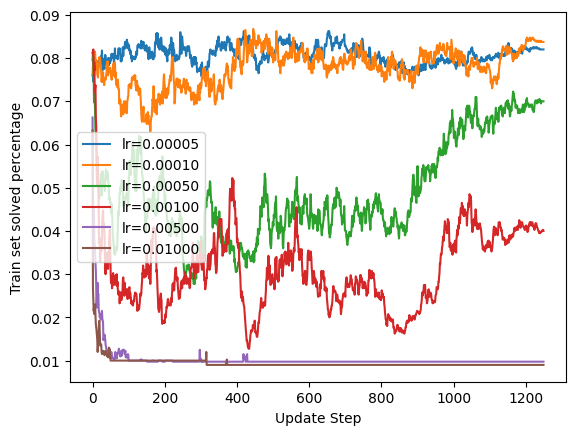

In [20]:
lr_search = jnp.array([0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01])
for i in range(len(lr_search)):
    plt.plot(
        loss_info["loss_info"]["eval_train/solved_percentage"][i].mean(0),
        label="lr={:.5f}".format(lr_search[i]),
    )
plt.legend()
plt.xlabel("Update Step")
plt.ylabel("Train set solved percentage")
plt.show()

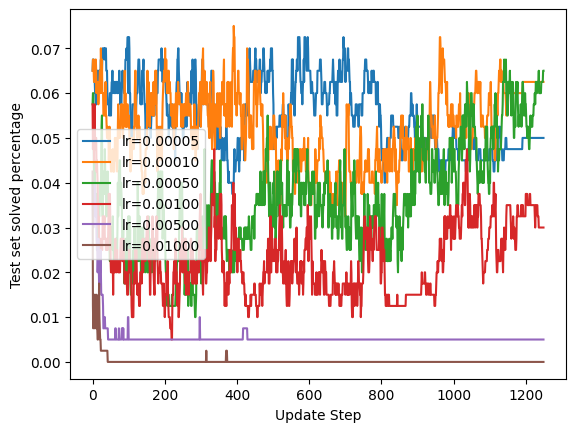

In [19]:
lr_search = jnp.array([0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01])
for i in range(len(lr_search)):
    plt.plot(
        loss_info["loss_info"]["eval_test/solved_percentage"][i].mean(0),
        label="lr={:.5f}".format(lr_search[i]),
    )
plt.legend()
plt.xlabel("Update Step")
plt.ylabel("Test set solved percentage")
plt.show()

In [15]:
config = TrainConfig(
    benchmark_id="level0_transformed_all",
    total_timesteps=2000_000,
    num_envs=8,
    num_minibatches=4,
    num_steps=100,
    num_train=1000,
    num_test=100
)

Num devices: 1, Num updates: 2500


In [ ]:
loss_info, elapsed_time = train(config)

Compiling and training...


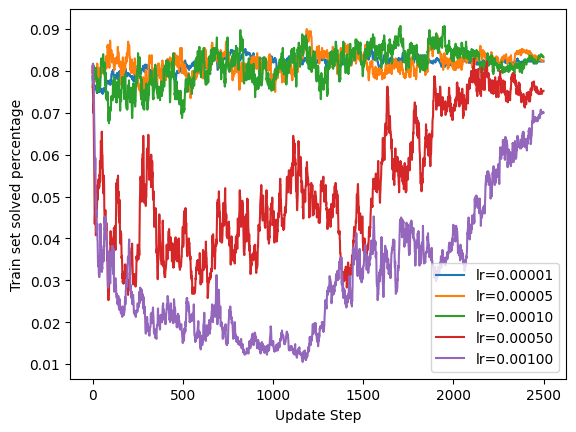

In [21]:
lr_search = jnp.array([0.00001, 0.00005, 0.0001, 0.0005, 0.001])
for i in range(len(lr_search)):
    plt.plot(
        loss_info["loss_info"]["eval_train/solved_percentage"][i].mean(0),
        label="lr={:.5f}".format(lr_search[i]),
    )
plt.legend()
plt.xlabel("Update Step")
plt.ylabel("Train set solved percentage")
plt.show()

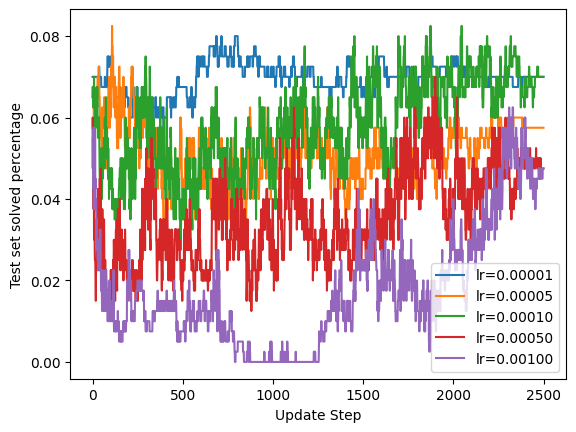

In [22]:
# lr_search = jnp.array([0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01])
lr_search = jnp.array([0.00001, 0.00005, 0.0001, 0.0005, 0.001])
for i in range(len(lr_search)):
    plt.plot(
        loss_info["loss_info"]["eval_test/solved_percentage"][i].mean(0),
        label="lr={:.5f}".format(lr_search[i]),
    )
plt.legend()
plt.xlabel("Update Step")
plt.ylabel("Test set solved percentage")
plt.show()

In [ ]:
# 125 updates, 10 min
# config = TrainConfig(
#     benchmark_id="level0_transformed_all",
#     total_timesteps=100_000,
#     num_envs=8,
#     num_minibatches=4,
#     num_steps=100,
#     num_train=1000,
#     num_test=100
# )

# 1250 updates, 1.5 hours
# config = TrainConfig(
#     benchmark_id="level0_transformed_all",
#     total_timesteps=1000_000,
#     num_envs=8,
#     num_minibatches=4,
#     num_steps=100,
#     num_train=1000,
#     num_test=100
# )

# 2500 updates, 9 hours
# config = TrainConfig(
#     benchmark_id="level0_transformed_all",
#     total_timesteps=2000_000,
#     num_envs=8,
#     num_minibatches=4,
#     num_steps=100,
#     num_train=1000,
#     num_test=100
# )

### 